In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random


In [50]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [51]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1007  0.103144  0.969381  0.896376  0.367376  0.871279  0.716328  0.945783   
200   0.377540  0.538863  0.295788  0.173369  0.418593 -0.016105  0.185674   
1640  0.449840  0.575202  0.352204  0.198227  0.531848  0.058054  0.230986   
605   0.190096  0.928668  0.876787  0.203723  0.853318  0.513469  0.333396   
1923  0.266310  0.944314  0.796670  0.230142  0.765674  0.410390  0.330761   
...        ...       ...       ...       ...       ...       ...       ...   
1388  0.250053  0.891487  0.894809  0.987234  0.974223  0.755085  0.981739   
1102  0.103401  0.995962  0.943976  0.984929  0.988857  0.947224  0.977410   
474   0.245348  0.930182  0.712047  0.206560  0.796940  0.371358  0.325866   
1026  0.129241  0.979139  0.977669  0.332092  0.991019  0.737218  0.932229   
1986  0.128471  0.947847  0.819980  0.315957  0.854316  0.510995  0.783697   

            F9        F5      F7      F12       F8  
1007  0.34

# RFE implement

In [52]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR


estimator = SVR(kernel="linear")
model = RFE(estimator, n_features_to_select=3, step=1)
model.fit(dataset,label)



RFE(estimator=SVR(kernel='linear'), n_features_to_select=3)

In [53]:

compressed_dataset_X= model.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

<class 'numpy.ndarray'>
3
[[0.8963761  0.36737589 0.36169208]
 [0.29578844 0.17336879 0.0594045 ]
 [0.35220372 0.19822695 0.09974582]
 ...
 [0.71204701 0.20656028 0.2140886 ]
 [0.97766895 0.3320922  0.80682643]
 [0.81998041 0.31595745 0.39106754]]


In [54]:
dataset_arr=dataset.to_numpy()


In [55]:
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [56]:
compressed_dataset_X_train= model.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= model.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[0.62095984 0.20088652 0.13961511]
 [0.26973555 0.17012411 0.10148874]
 [0.24622919 0.18244681 0.12810458]
 ...
 [0.9122429  0.39875887 0.79339143]
 [0.97277179 0.95585106 0.88416848]
 [0.75984329 0.22358156 0.20257807]]
<class 'numpy.ndarray'>
664
[[0.93281097 0.96808511 0.86165577]
 [0.23525955 0.18262411 0.08910675]
 [0.90577865 0.33829787 0.77777778]
 ...
 [0.55514202 0.21808511 0.20700799]
 [0.81684623 0.46950355 0.34041394]
 [0.34025465 0.18829787 0.04742193]]


# tune with random-forest

In [57]:
# train the model with random parameter
from sklearn.ensemble import RandomForestClassifier
# Preparing the regressor and fitting data with some parameters
model = RandomForestClassifier(

    criterion="entropy",
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=25,
    n_estimators=348,
) 

model.fit(compressed_dataset_X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=348)

In [58]:
# Finding mean absolute error
preds = model.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.11295180722891567

In [59]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(compressed_dataset_X)
target_train_tunned = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(compressed_dataset_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            'n_estimators':trial.suggest_int('n_estimators',50,500),
            'criterion':trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
            'max_depth':trial.suggest_int('max_depth',20,50),
            'min_samples_split':2,
            'min_samples_leaf':1,
            'max_features':trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'random_state':trial.suggest_int('random_state',0,10),
       
      
        }
    model = RandomForestClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [60]:
# this is the main optuna for optimizing a object-->"objective"
study = optuna.create_study(direction='minimize',study_name="RF_tune")

[I 2024-02-12 09:00:39,961] A new study created in memory with name: RF_tune


In [61]:

study.optimize(objective, n_trials=10) 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-12 09:00:40,858] Trial 0 finished with value: 0.12296564195298372 and parameters: {'n_estimators': 63, 'criterion': 'log_loss', 'max_depth': 33, 'max_features': 'log2', 'random_state': 9}. Best is trial 0 with value: 0.12296564195298372.


2212


[I 2024-02-12 09:00:45,593] Trial 1 finished with value: 0.11166365280289331 and parameters: {'n_estimators': 347, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'random_state': 9}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:00:48,862] Trial 2 finished with value: 0.11301989150090416 and parameters: {'n_estimators': 296, 'criterion': 'gini', 'max_depth': 37, 'max_features': 'log2', 'random_state': 5}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:00:52,525] Trial 3 finished with value: 0.11980108499095841 and parameters: {'n_estimators': 148, 'criterion': 'log_loss', 'max_depth': 35, 'max_features': None, 'random_state': 9}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:00:53,414] Trial 4 finished with value: 0.11754068716094032 and parameters: {'n_estimators': 67, 'criterion': 'entropy', 'max_depth': 38, 'max_features': 'sqrt', 'random_state': 4}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:00:56,534] Trial 5 finished with value: 0.11392405063291139 and parameters: {'n_estimators': 235, 'criterion': 'entropy', 'max_depth': 29, 'max_features': 'log2', 'random_state': 9}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:01:03,054] Trial 6 finished with value: 0.11437613019891502 and parameters: {'n_estimators': 485, 'criterion': 'log_loss', 'max_depth': 41, 'max_features': 'log2', 'random_state': 10}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:01:07,372] Trial 7 finished with value: 0.1166365280289331 and parameters: {'n_estimators': 325, 'criterion': 'entropy', 'max_depth': 37, 'max_features': 'log2', 'random_state': 4}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:01:10,162] Trial 8 finished with value: 0.11934900542495479 and parameters: {'n_estimators': 212, 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 6}. Best is trial 1 with value: 0.11166365280289331.


2212


[I 2024-02-12 09:01:11,262] Trial 9 finished with value: 0.11618444846292948 and parameters: {'n_estimators': 83, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'random_state': 1}. Best is trial 1 with value: 0.11166365280289331.


2212
Number of finished trials: 10
Best trial: {'n_estimators': 347, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'random_state': 9}


In [62]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value:  0.11166365280289331
  Params: 
    n_estimators: 347
    criterion: entropy
    max_depth: 25
    max_features: sqrt
    random_state: 9


# fit the R-F

In [63]:

K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [64]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train = np.array(compressed_dataset_X_train)
target_train = np.array(y_train)

test = np.array(compressed_dataset_X_test)
# target_train = df_train['congestion'].values

test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(compressed_dataset_X_train), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    rf_params = study.best_trial.params
    model = RandomForestClassifier(**rf_params)
    model.fit(train_X, train_y)
    # for train accuracy
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

0.12338501291989665


In [65]:
target_test = np.array(y_test)
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)

# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds.round())
print(test_Acc_SVC)

0.8990963855421686


In [66]:
valid_Acc=accuracy_score(target_train,oof_preds)
print(valid_Acc)

0.8979328165374677


In [67]:
train_Acc=model.score(compressed_dataset_X_train,y_train)
print(train_Acc)

0.9832041343669251


In [68]:
test_Acc=model.score(compressed_dataset_X_test,y_test)
print(test_Acc)

0.8945783132530121


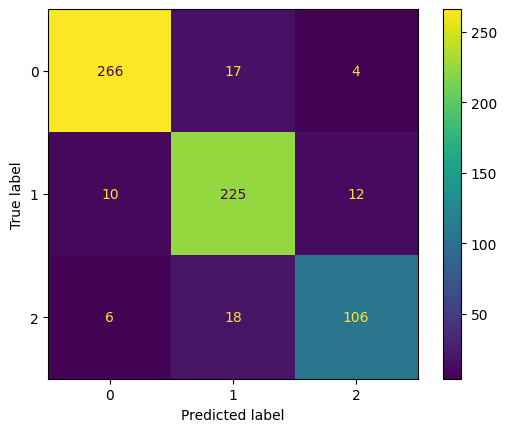

In [69]:
############# plot confusion matrix ############

from sklearn import metrics

cm = metrics.confusion_matrix(target_test, test_preds.round())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [80]:
# trial = study.best_trial.params
trial
trial['max_depth']=5
trial
# del trial['n_estimators']

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'random_state': 9}

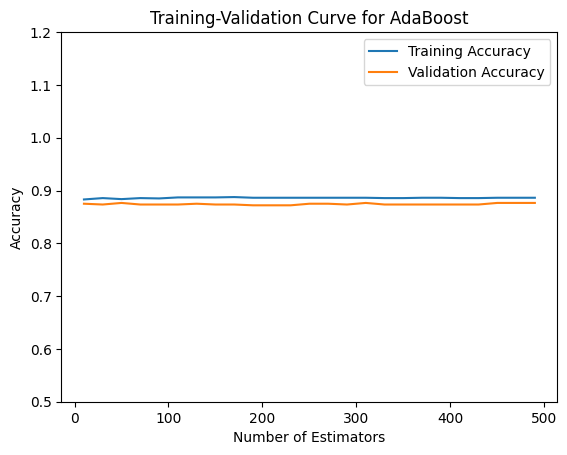

In [81]:
# ########## training-testing curve (with tuned D tree) ############


# Set different values for the number of estimators (weak learners)
# 10, 30, 40, 50, 60, 70, 80, 90, 100, 110,120,130,140,150
n_estimators_values = []

train_scores = []
val_scores = []
# base_estimator = DecisionTreeClassifier(max_depth=1)

# Train AdaBoost classifier with different number of estimators
for n_estimators in range(10,500,20):
    n_estimators_values.append(n_estimators)
    # rf_params = study.best_trial.params
    model = RandomForestClassifier(**trial,n_estimators=n_estimators)
    model.fit(compressed_dataset_X_train, y_train)
    
    # Calculate training accuracy
    train_pred = model.predict(compressed_dataset_X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_scores.append(train_accuracy)
    
    # Calculate validation accuracy
    val_pred = model.predict(compressed_dataset_X_test)
    val_accuracy = accuracy_score(y_test, val_pred)
    val_scores.append(val_accuracy)

# Plot training-validation curve
plt.plot(n_estimators_values, train_scores, label='Training Accuracy')
plt.plot(n_estimators_values, val_scores, label='Validation Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.2)
plt.title('Training-Validation Curve for AdaBoost')
plt.legend()
plt.show()
